In [78]:
from utils.converters import df_to_XY
from utils.readers import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Read data
## M&A Volume

In [2]:
df = read_acquiror_uk()
df['Date'] = df['Date'].dt.to_period('M')
df

,Date,Target Name,Target Industry Sector,Target\r\nNation,Acquiror Name,Acquiror Industry Sector,Acquiror\r\nNation,%\r\nof\r\nShares\r\nAcq.,%\r\nOwned\r\nAfter\r\nTrans-\r\naction,Value\r\nof\r\nTransaction\r\n($mil),Acquiror\r\nTicker\r\nSymbol,Target\r\nTicker\r\nSymbol,Acquiror\r\nDatastream\r\nCode,Target\r\nDatastream\r\nCode
0,2000-01,Beltpacker PLC,"Soaps, Cosmetics, and Personal-Care Products",United Kingdom,3i Group PLC,"Investment & Commodity Firms,Dealers,Exchanges",United Kingdom,30.4,30.4,NaN,III,NaN,960338,NaN
1,2000-01,Intellex SRL,Prepackaged Software,Italy,3i Group PLC,"Investment & Commodity Firms,Dealers,Exchanges",United Kingdom,100.0,100.0,NaN,III,NaN,960338,NaN
2,2000-01,Premier Womenswear,Amusement and Recreation Services,United Kingdom,Emap PLC,"Printing, Publishing, and Allied Services",United Kingdom,100.0,100.0,NaN,EMA,NaN,910283,NaN
3,2000-01,Supergrif Kitchen And Bath,"Stone, Clay, Glass, and Concrete Products",Spain,Delta PLC,Metal and Metal Products,United Kingdom,100.0,100.0,NaN,DLTA,NaN,901150,NaN
4,2000-01,Tranman Solutions Ltd,Prepackaged Software,United Kingdom,Lex Service PLC,Miscellaneous Retail Trade,United Kingdom,50.0,50.0,1.503,LEXL,NaN,900959,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16763,2022-01,Michael J Field Consulting,Business Services,United Kingdom,XPS Pensions Group PLC,Business Services,United Kingdom,100.0,100.0,5.006,XAF,NaN,9030AZ,NaN
16764,2022-05,Hellenic Minerals IKE,Mining,Greece,Rockfire Resources PLC,Mining,United Kingdom,100.0,100.0,.93,ROCK,NaN,86900D,NaN
16765,2021-12,Ego Eyewear Ltd,"Measuring, Medical, Photo Equipment; Clocks",Sweden,Inspecs Group PLC,"Measuring, Medical, Photo Equipment; Clocks",United Kingdom,100.0,100.0,NaN,SPEC,NaN,9605JM,NaN
16766,2021-12,Hunting Energy Svcs (UK) Ltd,Oil and Gas; Petroleum Refining,United Kingdom,Hunting PLC,Machinery,United Kingdom,40.0,100.0,NaN,HNTIY\r\nHTG,NaN,917509,NaN


In [3]:
out = {'date': [], 'vol': []}
for y in range(2000, 2022):
    for m in range(1, 13):
        i = f"{y}-{m}"
        d = df[df['Date'] == i]
        out['date'].append(i)
        out['vol'].append(len(d))

In [4]:
vol_monthly = pd.DataFrame(out)
vol_monthly

,date,vol
0,2000-1,101
1,2000-2,117
2,2000-3,158
3,2000-4,139
4,2000-5,113
...,...,...
259,2021-8,60
260,2021-9,57
261,2021-10,60
262,2021-11,53


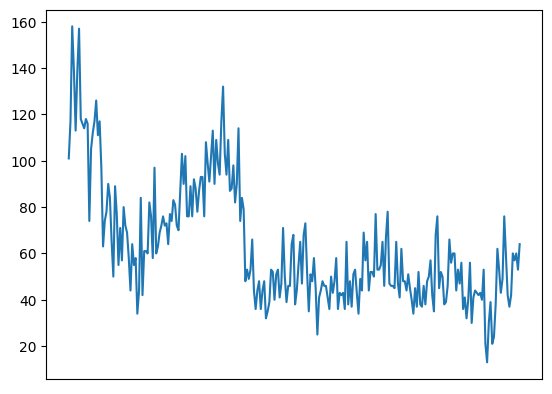

In [5]:
ax = plt.gca()
ax.plot(vol_monthly.date, vol_monthly.vol)
ax.set_xticks([]);

## GDP

In [6]:
gdp_quarter = read_gdp()
until = '2022-01'
gdp_quarter['Date'] = gdp_quarter['Date'].dt.to_period('M')
gdp_quarter = gdp_quarter[gdp_quarter['Date'] < until]
gdp_quarter

,Date,UK_GDP
0,2000-02,403407.0
1,2000-05,406049.0
2,2000-08,408120.0
3,2000-11,409871.0
4,2001-02,413381.0
...,...,...
83,2020-11,509621.0
84,2021-02,503663.0
85,2021-05,536608.0
86,2021-08,546084.0


In [9]:
res = []
for i in range(int(len(vol_monthly)/3)):
    s = vol_monthly[3*i: 3*(i+1)]
    res.append(s.vol.sum())
gdp_quarter['vol'] = res
gdp_quarter

,Date,UK_GDP,vol
0,2000-02,403407.0,376
1,2000-05,406049.0,391
2,2000-08,408120.0,391
3,2000-11,409871.0,348
4,2001-02,413381.0,291
...,...,...,...
83,2020-11,509621.0,153
84,2021-02,503663.0,168
85,2021-05,536608.0,138
86,2021-08,546084.0,159


## Variables

In [11]:
until = '2022-01'
var_monthly = read_variable_monthly()
var_monthly['Date'] = var_monthly['Date'].dt.to_period('M')
var_monthly = var_monthly[var_monthly['Date'] < until]

res = {'EXUSUK': [], 'Interest_Rate': [], 'SMI': []}
for i in range(int(len(var_monthly)/3)):
    s = var_monthly[3*i: 3*(i+1)]
    res['EXUSUK'].append(s.EXUSUK.mean())
    res['Interest_Rate'].append(s['Interest_Rate'].mean())
    res['SMI'].append(s.SMI.mean())
gdp_quarter['EXUSUK'] = res['EXUSUK']
gdp_quarter['Interest_Rate'] = res['Interest_Rate']
gdp_quarter['SMI'] = res['SMI']
gdp_quarter

,Date,UK_GDP,vol,EXUSUK,Interest_Rate,SMI
0,2000-02,403407.0,376,1.606767,5.916667,1241.948000
1,2000-05,406049.0,391,1.533500,6.000000,1193.004000
2,2000-08,408120.0,391,1.476700,6.000000,1181.404333
3,2000-11,409871.0,348,1.446433,6.000000,1121.388000
4,2001-02,413381.0,291,1.458167,5.833333,1112.460333
...,...,...,...,...,...,...
83,2020-11,509621.0,153,1.320400,0.100000,911.964667
84,2021-02,503663.0,168,1.379033,0.100000,1045.408667
85,2021-05,536608.0,138,1.398467,0.100000,1131.969000
86,2021-08,546084.0,159,1.377900,0.100000,1151.498333


# Regression
## Monthly variables

In [20]:
gdp_quarter[gdp_quarter.Date < '2019-01']

,Date,UK_GDP,vol,EXUSUK,Interest_Rate,SMI
0,2000-02,403407.0,376,1.606767,5.916667,1241.948000
1,2000-05,406049.0,391,1.533500,6.000000,1193.004000
2,2000-08,408120.0,391,1.476700,6.000000,1181.404333
3,2000-11,409871.0,348,1.446433,6.000000,1121.388000
4,2001-02,413381.0,291,1.458167,5.833333,1112.460333
...,...,...,...,...,...,...
71,2017-11,546185.0,179,1.327433,0.416667,1194.123000
72,2018-02,547003.0,147,1.392033,0.500000,1243.995667
73,2018-05,549491.0,123,1.361433,0.500000,1221.023000
74,2018-08,552545.0,182,1.303533,0.666667,1188.490000


In [67]:
x_index = ['EXUSUK', 'Interest_Rate', 'SMI', 'UK_GDP']
y_index = ['vol']

data = gdp_quarter
sep = '2016-6'
data_before = gdp_quarter[gdp_quarter.Date < sep]
data_after = gdp_quarter[gdp_quarter.Date > sep]

X_train, Y_train = df_to_XY(data_before, xkeys=x_index, ykeys=y_index)
X_test, Y_test = df_to_XY(data_after, xkeys=x_index, ykeys=y_index)

model_before = LinearRegression().fit(X_train, Y_train)
model_after = LinearRegression().fit(X_test, Y_test)

model_before.score(X_train, Y_train), model_after.score(X_test, Y_test)

(0.8886608520434129, 0.4971524107221761)

In [68]:
model_before.coef_

array([[-1.49747732e+02,  2.57013346e+01,  2.00870558e-01,
        -5.89763427e-04]])

In [15]:
model_before.intercept_

array([357.86576445])

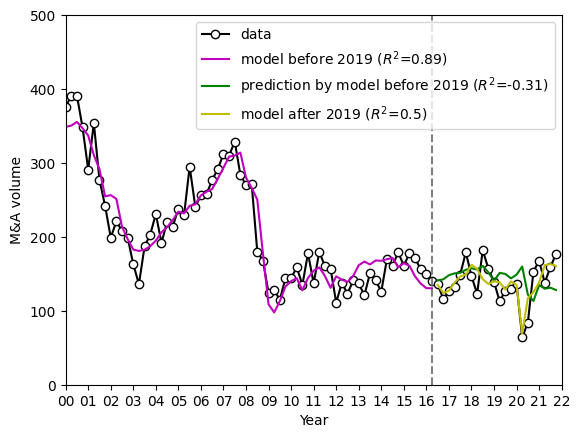

In [86]:
ax = plt.gca()

x_data = data.Date.astype(str)
ax.plot(x_data, data.vol, marker='o', color='k', mfc='white', ls='-', label='data')

Y_train_pred = model_before.predict(X_train)
x_data_before = data_before.index
r = r2_score(Y_train, Y_train_pred,)
ax.plot(x_data_before, Y_train_pred, color='m',
        label=f'model before 2019 ($R^2$={round(r, 2)})')

x_data_after = data_after.index
Y_test_pred = model_before.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='g',
        label=f'prediction by model before 2019 ($R^2$={round(r, 2)})')

Y_test_pred = model_after.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='y',
        label=f'model after 2019 ($R^2$={round(r, 2)})')

ax.axvline(65, ls='--', color='gray')
plt.xticks(ticks=range(0, 89, 4), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
ax.set_xlim(0, 88)
ax.set_ylabel('M&A volume')
ax.set_xlabel('Year')
ax.set_ylim(0, 500)
ax.legend(loc=0, frameon=True);

In [71]:
model_before.score(X_train, Y_train)

0.8886608520434129

In [70]:
model_after.score(X_test, Y_test)

0.4971524107221761

In [72]:
data_before

,Date,UK_GDP,vol,EXUSUK,Interest_Rate,SMI
0,2000-02,403407.0,376,1.606767,5.916667,1241.948000
1,2000-05,406049.0,391,1.533500,6.000000,1193.004000
2,2000-08,408120.0,391,1.476700,6.000000,1181.404333
3,2000-11,409871.0,348,1.446433,6.000000,1121.388000
4,2001-02,413381.0,291,1.458167,5.833333,1112.460333
...,...,...,...,...,...,...
61,2015-05,516141.0,178,1.533333,0.500000,1275.258333
62,2015-08,518365.0,171,1.549200,0.500000,1222.287667
63,2015-11,522194.0,156,1.517267,0.500000,1161.299333
64,2016-02,524102.0,150,1.431033,0.500000,1071.977333


In [ ]:
Y_test_pred